In [2]:
import pandas as pd
import numpy as np
import joblib
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import train_test_split
import progressbar
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [4]:
cluster_encoder = joblib.load("../cluster_encoder.joblib")
service_class_cluster_model = CatBoostClassifier()      # parameters not required.
service_class_cluster_model = service_class_cluster_model.load_model('../service_class_cluster_model.cbm')

In [5]:
service_codes = pd.read_excel("../data/hardcoded/Коды услуг.xlsx")
service_codes = service_codes.dropna()
service_codes = service_codes.drop_duplicates()
service_codes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 321 entries, 0 to 430
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID услуги     321 non-null    int64 
 1   Класс услуги  321 non-null    object
dtypes: int64(1), object(1)
memory usage: 7.5+ KB


In [6]:
df = pd.read_excel("../data/train/Счета объединенные.xlsx")
df = df.fillna(method='ffill')
df["Кластер"] = None
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124661 entries, 0 to 124660
Data columns (total 10 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   Компания                                124661 non-null  int64         
 1   Год                                     124661 non-null  int64         
 2   Номер счета                             124661 non-null  int64         
 3   Позиция счета                           124661 non-null  int64         
 4   ID услуги                               124661 non-null  int64         
 5   ID договора                             124661 non-null  object        
 6   Дата отражения счета в учетной системе  124661 non-null  datetime64[ns]
 7   Стоимость без НДС                       124661 non-null  float64       
 8   Сумма площадей                          124661 non-null  float64       
 9   Кластер                              

In [7]:
with progressbar.ProgressBar(max_value=df.shape[0]) as bar:
    for _, row in df.iterrows():
        value = row["ID договора"][9:]
        service_id = row["ID услуги"]
        #df.loc[_, "ID договра"] = row["ID договра"][9:]
        duplicated = service_codes.query("`ID услуги` == @service_id")
        duplicated_classes = duplicated["Класс услуги"].to_list()[0]
        df.loc[_, "Дата отражения счета в учетной системе"] = row["Дата отражения счета в учетной системе"].month #получение месяца вместо даты 
        cluster_for_row = pd.DataFrame({"ID услуги": [service_id], "Класс услуги": cluster_encoder.fit_transform([duplicated_classes])})
        df.loc[_, "Кластер"] = service_class_cluster_model.predict(cluster_for_row)[0]
        bar.update(_)
df["ID договора"] = df["ID договора"].str.split('/').str[-1]

  0% (0 of 124661) |                     | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% (24 of 124661) |                    | Elapsed Time: 0:00:00 ETA:   0:09:09
  0% (38 of 124661) |                    | Elapsed Time: 0:00:00 ETA:   0:11:20
  0% (62 of 124661) |                    | Elapsed Time: 0:00:00 ETA:   0:10:18
  0% (83 of 124661) |                    | Elapsed Time: 0:00:00 ETA:   0:10:13
  0% (102 of 124661) |                   | Elapsed Time: 0:00:00 ETA:   0:10:25
  0% (128 of 124661) |                   | Elapsed Time: 0:00:00 ETA:   0:09:55
  0% (153 of 124661) |                   | Elapsed Time: 0:00:00 ETA:   0:09:40
  0% (182 of 124661) |                   | Elapsed Time: 0:00:00 ETA:   0:09:16
  0% (213 of 124661) |                   | Elapsed Time: 0:00:00 ETA:   0:08:56
  0% (241 of 124661) |                   | Elapsed Time: 0:00:01 ETA:   0:08:46
  0% (268 of 124661) |                   | Elapsed Time: 0:00:01 ETA:   0:08:41
  0% (298 of 124661) |                  

In [8]:
#df = df.dropna()
#df = df.reset_index(drop=True)
#df.info()
df.to_excel("../data/train/Счета объединенные кластеризованные.xlsx", index=False)
df.head(5)

,Компания,Год,Номер счета,Позиция счета,ID услуги,ID договора,Дата отражения счета в учетной системе,Стоимость без НДС,Сумма площадей,Кластер
0,3800,2023,5006159023,1,800003254,74368,1,611.16,645.7,[9]
1,3800,2023,5006159023,2,800003261,74368,1,799.40,645.7,[9]
2,3800,2023,5006159026,1,800001855,74367,1,16094.05,645.7,[0]
3,3800,2023,5006159131,1,800003662,74376,1,1403.71,56.9,[3]
4,3800,2023,5006159148,1,800003662,74373,1,2259.62,56.9,[3]


In [26]:
x = df.drop(["Стоимость без НДС"], axis=1)
y = df["Стоимость без НДС"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
cat_features = ['ID договора']
regressor = CatBoostRegressor()
#regressor.load_model("../predict_future.cbm")

In [103]:
regressor = CatBoostRegressor(iterations=100, depth=14, learning_rate=0.05, grow_policy='Depthwise', loss_function="Quantile", verbose=1)
regressor.fit(x_train, y_train, verbose=10, cat_features=cat_features)

0:	learn: 21830.2332548	total: 4.38s	remaining: 7m 14s
10:	learn: 19573.1597014	total: 46.8s	remaining: 6m 18s
20:	learn: 18048.9110778	total: 1m 34s	remaining: 5m 55s
30:	learn: 16965.7846444	total: 2m 23s	remaining: 5m 19s
40:	learn: 16053.5779136	total: 3m 13s	remaining: 4m 38s
50:	learn: 15344.3218394	total: 4m	remaining: 3m 51s
60:	learn: 14859.8847904	total: 4m 49s	remaining: 3m 4s
70:	learn: 14467.9472112	total: 5m 35s	remaining: 2m 16s
80:	learn: 14182.0623179	total: 6m 16s	remaining: 1m 28s
90:	learn: 13910.3463460	total: 6m 59s	remaining: 41.5s
99:	learn: 13745.2691354	total: 7m 35s	remaining: 0us


In [111]:
# Предсказания на тестовых данных
from sklearn.metrics import accuracy_score

print(regressor.score(x_test, y_test))
print(regressor.score(x, y))
y_pred = regressor.predict(x_test)
y_pred = y_pred + (y_pred.min()) * -1
err = ((sum(y_test) - sum(y_pred)) / sum(y_test)) * 100

print(err)
print(y_pred.min(), y_pred.max())
print(y_test.min(), y_test.max())

# # Оценка качества модели
#accuracy = accuracy_score(y_pred, y_test)

# print(f'Accuracy: {accuracy}')

0.4530313800600523
0.49389174480102205
0.4310055145926842
0.0 3762362.077368767
0.0 8177433.35


In [112]:
regressor.save_model("../predict_future_current_best_WTF.cbm")

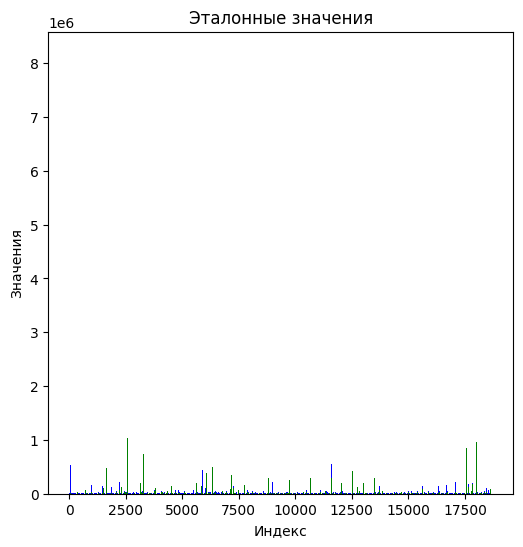

In [109]:
import matplotlib.pyplot as plt
# Построение гистограмм
plt.figure(figsize=(6, 6))

plt.bar(range(y_pred.size), y_pred, color='blue')
plt.xlabel('Индекс')
plt.ylabel('Значения')
plt.title('Предсказанные значения')

plt.bar(range(y_test.size), y_test, color='green')
plt.xlabel('Индекс')
plt.ylabel('Значения')
plt.title('Эталонные значения')

plt.show()